In [2]:
setwd("/projects/CARDIPS/analysis/epigenome_resource")
source("analyses/jennifer/notebooks/functions.R")

set.seed(5366)

# Figure 5a: Annotate each GWAS loci based on the QTL types it colocalized with

## read Supplemental Table for GWAS Colocalization

In [21]:
table = fread("manuscript/tables/Table_SX_All_GWAS_Signals.txt", data.table = F) 

head(table,2)

,Trait_Description,Trait_ID,GWAS_Index,Tissue,Cluster_ID,Membership,QTL_Index,QTL_Combination,QTL_Combination_Collapse,Colocalized_with_Fetal_Unique_QTL,Fetal_Unique_GWAS_Locus,GWAS_ID
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>
1,HDL Cholesterol,biomarkers-30760-both_sexes-irnt.meta,1_26844926,PPC,PPC_1202,Singleton,1_26693642,eQTL,eQTL,FALSE,FALSE,1_26844926 biomarkers-30760-both_sexes-irnt.meta
2,HDL Cholesterol,biomarkers-30760-both_sexes-irnt.meta,1_178608472,PPC,PPC_2021,Singleton,1_171486183,eQTL,eQTL,FALSE,FALSE,1_178608472 biomarkers-30760-both_sexes-irnt.meta


## total number of independent loci per trait

In [45]:
total_signals_per_trait = table %>% select(Trait_Description, GWAS_Index) %>% distinct() %>% dplyr::count(Trait_Description)
total_signals_per_trait

Trait_Description,n
<chr>,<int>
Aging,26
Angina Pectoris,26
Atrial Fibrillation,59
Birth Weight,53
Body Mass Index,847
Childhood Obesity,12
Fasting Glucose,80
HDL Cholesterol,657
Ischemic Heart Disease,58


## aggregate QTL types for each GWAS locus

In [31]:
toplot = table %>%
            select(Trait_Description, GWAS_Index, QTL_Combination_Collapse, GWAS_ID) %>%
            filter(QTL_Combination_Collapse != "") %>%
            distinct() %>%
            group_by(GWAS_ID, Trait_Description) %>%
            dplyr::summarise(QTL_Combination_Collapse = paste(QTL_Combination_Collapse, collapse = "-")) 

table(toplot$QTL_Combination_Collapse)

head(toplot,2)

`summarise()` has grouped output by 'GWAS_ID'. You can override using the
`.groups` argument.



                            caQTL                  caQTL-caQTL-eQTL 
                              185                                 9 
                caQTL-caQTL-haQTL            caQTL-caQTL-haQTL-eQTL 
                                5                                 4 
caQTL-caQTL-haQTL-eQTL-caQTL-eQTL       caQTL-caQTL-haQTL-eQTL-eQTL 
                                4                                 1 
                       caQTL-eQTL                  caQTL-eQTL-caQTL 
                               73                                 8 
            caQTL-eQTL-caQTL-eQTL            caQTL-eQTL-caQTL-haQTL 
                                1                                 3 
      caQTL-eQTL-caQTL-haQTL-eQTL  caQTL-eQTL-caQTL-haQTL-eQTL-eQTL 
                               10                                 2 
                  caQTL-eQTL-eQTL             caQTL-eQTL-haQTL-eQTL 
                               10                                 3 
                      caQTL-haQTL

GWAS_ID,Trait_Description,QTL_Combination_Collapse
<chr>,<chr>,<chr>
10_103637983 icd10-I48-both_sexes.meta,Atrial Fibrillation,caQTL-haQTL
10_116829668 continuous-23104-both_sexes-irnt.meta,Body Mass Index,caQTL


## sort and de-duplicate QTL_Combination_Collapse column

In [33]:
toplot$QTL_Combination_Collapse = unlist(lapply(toplot$QTL_Combination_Collapse, function(x) { paste(sort(unique(unlist(strsplit(x, "-")))), collapse = "-") }))
table(toplot$QTL_Combination_Collapse)


           caQTL       caQTL-eQTL caQTL-eQTL-haQTL      caQTL-haQTL 
             185              130               70               42 
            eQTL       eQTL-haQTL            haQTL 
             126               13               47 

## check non-duplicate GWAS loci

In [36]:
toplot %>% filter(duplicated(GWAS_ID))

GWAS_ID,Trait_Description,QTL_Combination_Collapse
<chr>,<chr>,<chr>


## count GWAS loci per QTL type

In [138]:
toplot2 = toplot %>% ungroup() %>% group_by(Trait_Description, QTL_Combination_Collapse) %>% dplyr::count()

head(toplot2,4)

Trait_Description,QTL_Combination_Collapse,n
<chr>,<chr>,<int>
Aging,caQTL,2
Aging,caQTL-eQTL,2
Aging,caQTL-eQTL-haQTL,1
Aging,eQTL,2


## add colums for data labels

In [139]:
toplot2 = merge(toplot2, total_signals_per_trait %>% dplyr::rename(total = n), by = "Trait_Description") %>%
            mutate(pct = n / total * 100,
                   y_label = paste(Trait_Description, paste0("(Total=", total, ")"), sep = "\n"),
                   QTL_Combination_Collapse = gsub("-", ",", QTL_Combination_Collapse)) %>%
            ungroup() %>% group_by(Trait_Description) %>%
            dplyr::mutate(total_pct_coloc = sum(pct),
                   total_n = sum(n),
                   bar_label = paste0("n=", total_n, " (", signif(total_pct_coloc, 2), "%)")) %>%
            filter(n != 0)
            

In [140]:
head(toplot2,2)

Trait_Description,QTL_Combination_Collapse,n,total,pct,y_label,total_pct_coloc,total_n,bar_label
<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<dbl>,<int>,<chr>
Aging,caQTL,2,26,7.692308,Aging (Total=26),26.92308,7,n=7 (27%)
Aging,"caQTL,eQTL",2,26,7.692308,Aging (Total=26),26.92308,7,n=7 (27%)


## set order to traits by increasing number of colocalizations

In [141]:
order = toplot2 %>% 
    select(y_label, total_pct_coloc) %>% 
    distinct() %>% 
    arrange(desc(total_pct_coloc))

order$y_label

toplot2$y_label = factor(toplot2$y_label, levels = order$y_label)

Adding missing grouping variables: `Trait_Description`


[1] "Birth Weight\n(Total=53)"           "Type 2 Diabetes\n(Total=221)"      
 [3] "Atrial Fibrillation\n(Total=59)"    "Pulse Rate\n(Total=95)"            
 [5] "Aging\n(Total=26)"                  "Parental Lifespan\n(Total=20)"     
 [7] "Childhood Obesity\n(Total=12)"      "HDL Cholesterol\n(Total=657)"      
 [9] "Type 1 Diabetes\n(Total=103)"       "LDL Direct\n(Total=278)"           
[11] "Fasting Glucose\n(Total=80)"        "Body Mass Index\n(Total=847)"      
[13] "Myocardial Infarction\n(Total=19)"  "Angina Pectoris\n(Total=26)"       
[15] "Ischemic Heart Disease\n(Total=58)" "Ventricular Rate\n(Total=12)"      
[17] "QRS Duration\n(Total=31)"

## set order to qtl types

In [142]:
qtl_order = c("caQTL", "haQTL", "eQTL", "caQTL,haQTL", "caQTL,eQTL", "eQTL,haQTL", "caQTL,eQTL,haQTL")
toplot2$QTL_Combination_Collapse = factor(toplot2$QTL_Combination_Collapse, levels = qtl_order)

In [143]:
head(toplot2,2)

Trait_Description,QTL_Combination_Collapse,n,total,pct,y_label,total_pct_coloc,total_n,bar_label
<chr>,<fct>,<int>,<int>,<dbl>,<fct>,<dbl>,<int>,<chr>
Aging,caQTL,2,26,7.692308,Aging (Total=26),26.92308,7,n=7 (27%)
Aging,"caQTL,eQTL",2,26,7.692308,Aging (Total=26),26.92308,7,n=7 (27%)


## rename columns

In [144]:
toplot3 = toplot2 %>%
           dplyr::rename(QTL_Annotations = QTL_Combination_Collapse) %>%
           dplyr::rename(Number_Signals_with_Annotation = n) %>%
           dplyr::rename(Total_Indep_Signals_for_Trait = total) %>%
           dplyr::rename(Pct_Signals_Colocalized_with_Annotation = pct) %>%
           dplyr::rename(Bar_Label = bar_label) %>%
           dplyr::rename(Total_Pct_Colocalized = total_pct_coloc) %>%
           dplyr::rename(Total_Number_Signals_Colocalized = total_n) %>%
           dplyr::rename(Y_label = y_label) 

toplot3 %>% head(5)

Trait_Description,QTL_Annotations,Number_Signals_with_Annotation,Total_Indep_Signals_for_Trait,Pct_Signals_Colocalized_with_Annotation,Y_label,Total_Pct_Colocalized,Total_Number_Signals_Colocalized,Bar_Label
<chr>,<fct>,<int>,<int>,<dbl>,<fct>,<dbl>,<int>,<chr>
Aging,caQTL,2,26,7.692308,Aging (Total=26),26.92308,7,n=7 (27%)
Aging,"caQTL,eQTL",2,26,7.692308,Aging (Total=26),26.92308,7,n=7 (27%)
Aging,"caQTL,eQTL,haQTL",1,26,3.846154,Aging (Total=26),26.92308,7,n=7 (27%)
Aging,eQTL,2,26,7.692308,Aging (Total=26),26.92308,7,n=7 (27%)
Angina Pectoris,caQTL,3,26,11.538462,Angina Pectoris (Total=26),19.23077,5,n=5 (19%)


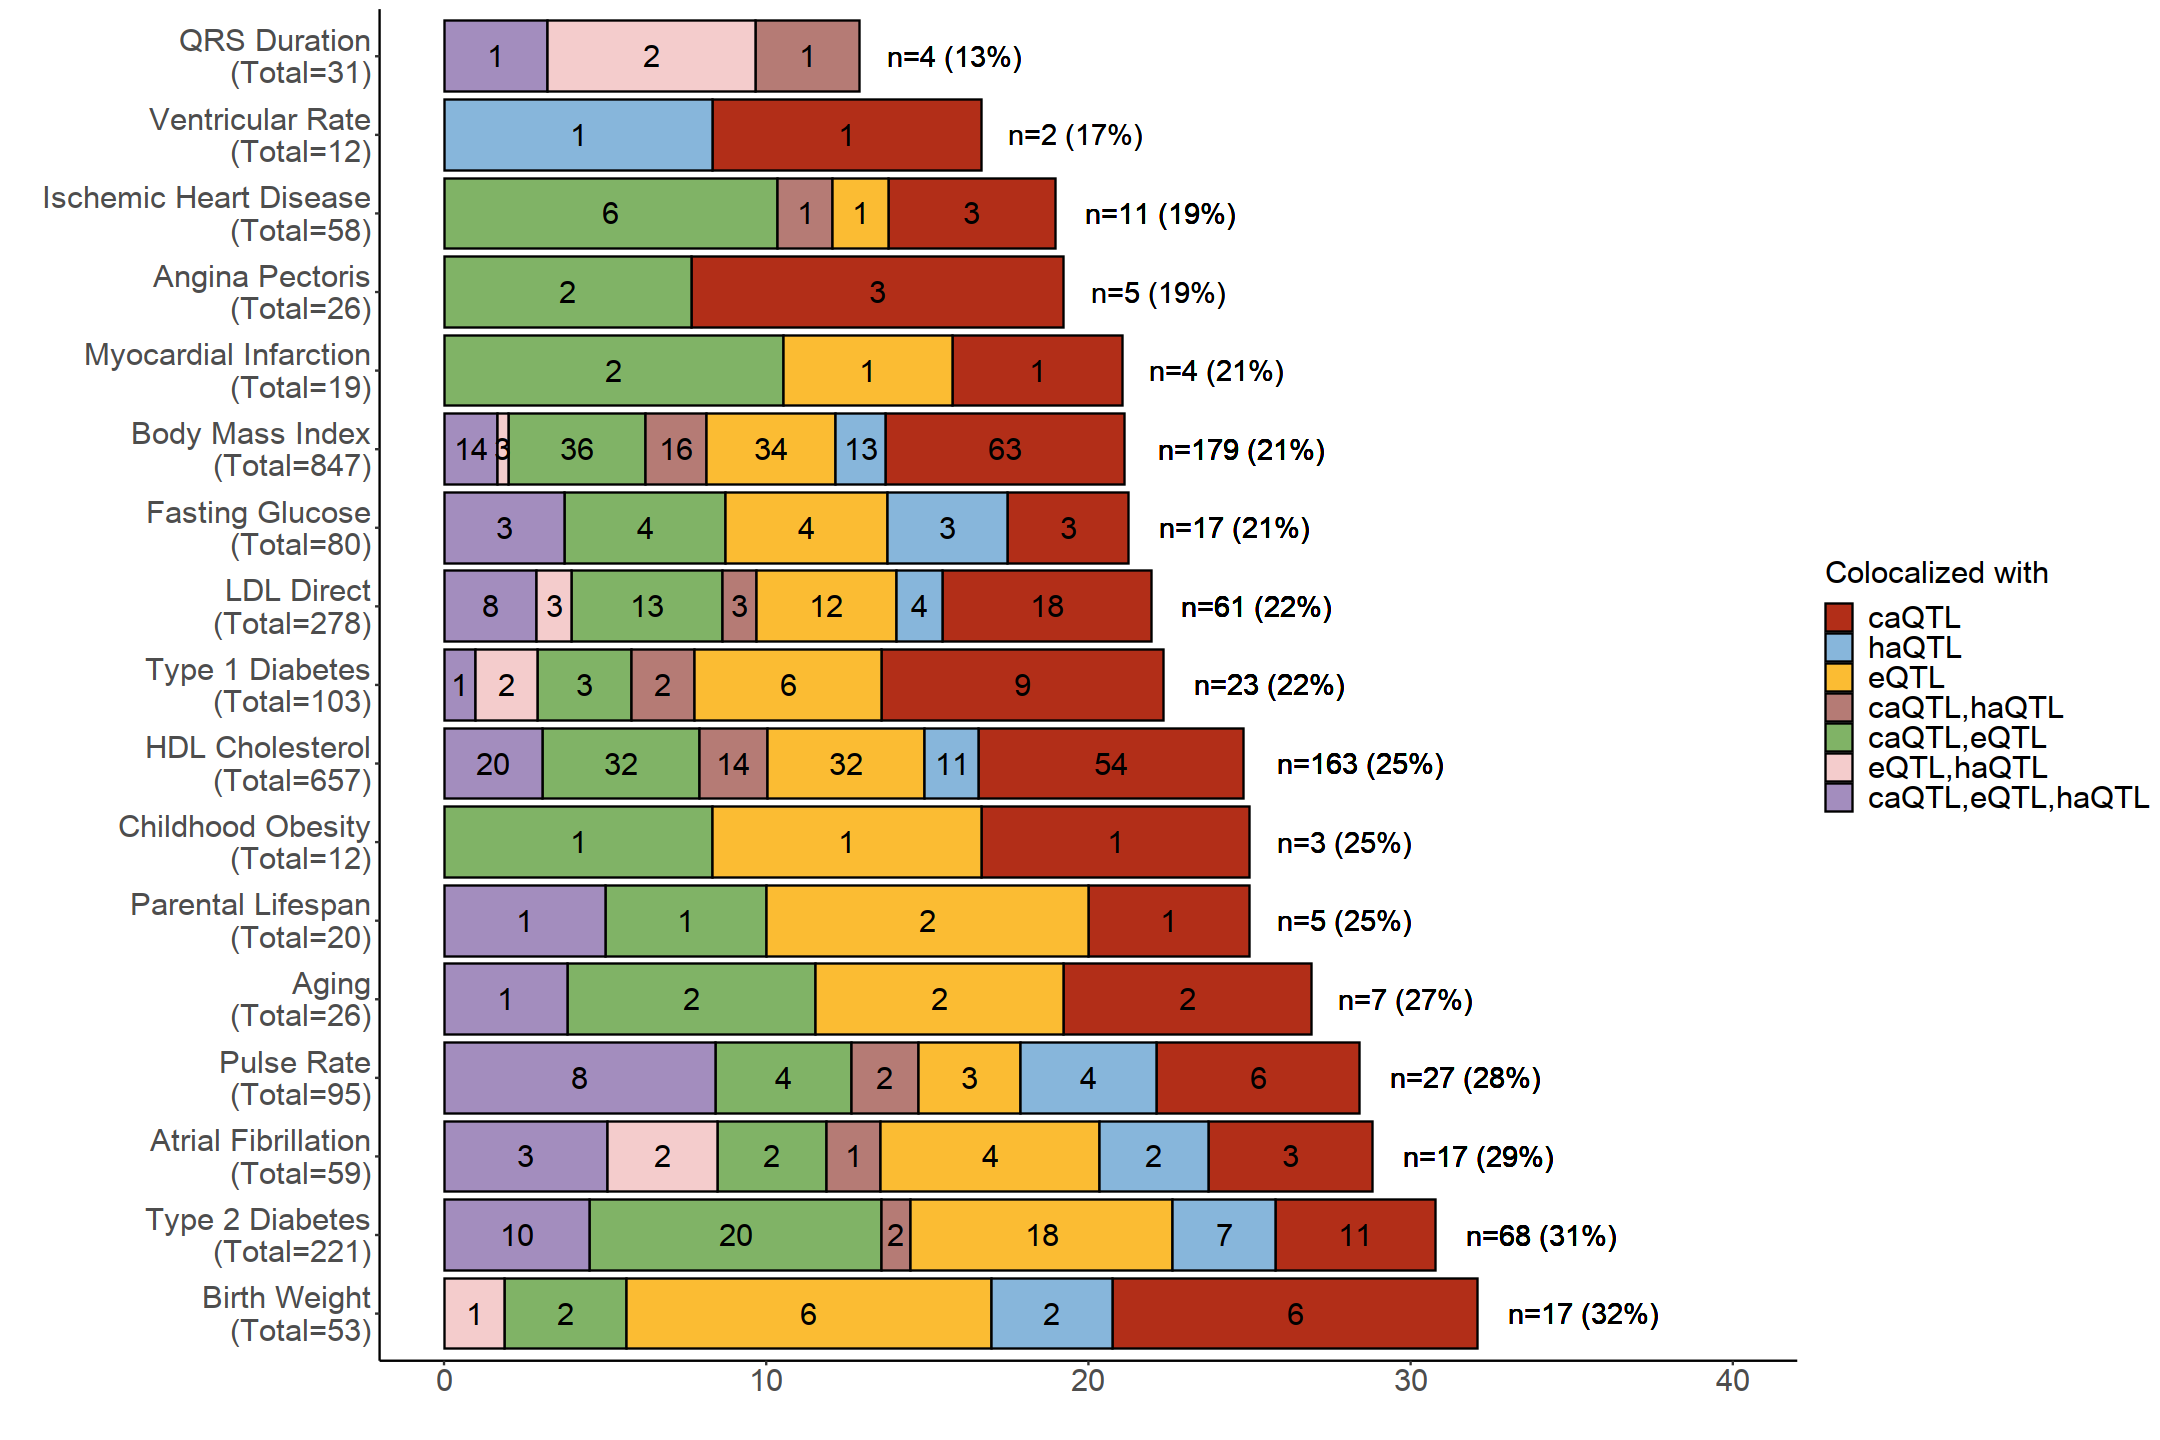

In [145]:
psize(w = 18, h = 12)
p0 = ggplot(toplot3, aes(x = Pct_Signals_Colocalized_with_Annotation, 
                    y = Y_label, 
                    fill = QTL_Annotations, 
                    label = Number_Signals_with_Annotation)) + 
    geom_bar(stat = "identity", color = "black") + 
    jn_classic + 
    theme(
        legend.text = element_text(size = 18),
        legend.title = element_text(size = 18)
    ) + xlab("") + ylab("") + 
    scale_fill_manual(values = c("#b22e18",
                                 "#87b6db",
                                 "#fbbc33", 
                                 "#b57b75",
                                 "#80b366",
                                 "#f4cccc",
                                 "#a38dbe"), 
                      name = "Colocalized with  ") +
     geom_text(position = position_stack(vjust = 0.5), size = 6.5) +
     geom_text(data = toplot3, aes(x = Total_Pct_Colocalized, y = Y_label, label = Bar_Label), color = "black",  hjust = -0.2, size = 6) + 
     xlim(0, 40)

p0

## plot all traits together

In [153]:
all = toplot3 %>% 
    ungroup() %>% 
    select(QTL_Annotations, Number_Signals_with_Annotation)  %>%
    mutate(Total_Number_Signals_Colocalized = sum(Number_Signals_with_Annotation)) %>%
    group_by(QTL_Annotations) %>%
    dplyr::mutate(Number_Signals_with_Annotation = sum(Number_Signals_with_Annotation)) %>%
    distinct() %>%
    ungroup() %>%
    mutate(Total_Indep_Signals_for_Trait = 2597) %>%
    dplyr::mutate(Pct_Signals_Colocalized_with_Annotation = Number_Signals_with_Annotation / Total_Indep_Signals_for_Trait * 100) %>%
    mutate(Total_Pct_Colocalized = sum(Pct_Signals_Colocalized_with_Annotation)) %>%
    mutate(Bar_Label = paste0("n=", Total_Number_Signals_Colocalized, " (", signif(Total_Pct_Colocalized, 2), "%)")) %>%
    mutate(Y_label = "All 17 Traits\n(Total=2597)",
           Trait_Description = "All 17 Traits")

all$QTL_Annotations = factor(all$QTL_Annotations, levels = qtl_order)

all 

sum(all$Number_Signals_with_Annotation)

QTL_Annotations,Number_Signals_with_Annotation,Total_Number_Signals_Colocalized,Total_Indep_Signals_for_Trait,Pct_Signals_Colocalized_with_Annotation,Total_Pct_Colocalized,Bar_Label,Y_label,Trait_Description
<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
caQTL,185,613,2597,7.1236042,23.60416,n=613 (24%),All 17 Traits (Total=2597),All 17 Traits
"caQTL,eQTL",130,613,2597,5.0057759,23.60416,n=613 (24%),All 17 Traits (Total=2597),All 17 Traits
"caQTL,eQTL,haQTL",70,613,2597,2.6954178,23.60416,n=613 (24%),All 17 Traits (Total=2597),All 17 Traits
eQTL,126,613,2597,4.8517520,23.60416,n=613 (24%),All 17 Traits (Total=2597),All 17 Traits
"caQTL,haQTL",42,613,2597,1.6172507,23.60416,n=613 (24%),All 17 Traits (Total=2597),All 17 Traits
"eQTL,haQTL",13,613,2597,0.5005776,23.60416,n=613 (24%),All 17 Traits (Total=2597),All 17 Traits
haQTL,47,613,2597,1.8097805,23.60416,n=613 (24%),All 17 Traits (Total=2597),All 17 Traits


[1] 613

Warning message in geom_text(data = all, aes(x = Total_Pct_Colocalized, y = Y_label, :
“Ignoring unknown parameters: `fill`”


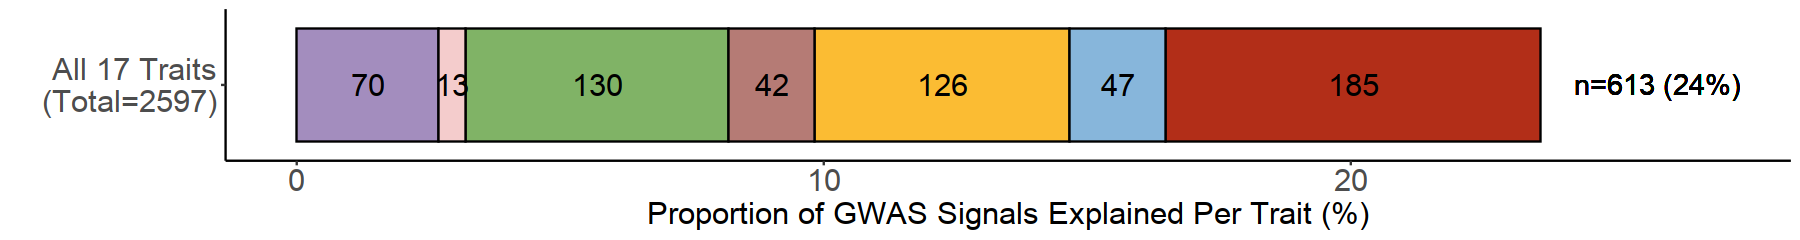

In [154]:
p1 = ggplot(all, aes(x = Pct_Signals_Colocalized_with_Annotation, y = Y_label, fill = QTL_Annotations, label = Number_Signals_with_Annotation)) + 
    geom_bar(stat = "identity", color = "black") + 
    jn_classic + 
    theme(
        legend.position = "none",
        legend.text = element_text(size = 18),
        legend.title = element_text(size = 18)
    ) + xlab("Proportion of GWAS Signals Explained Per Trait (%)") + ylab("") + 
    scale_fill_manual(values = c("#b22e18",
                                 "#87b6db",
                                 "#fbbc33", 
                                 "#b57b75",
                                 "#80b366",
                                 "#f4cccc",
                                 "#a38dbe"), 
                      name = "Colocalized with  ") +
     geom_text(position = position_stack(vjust = 0.5), size = 6.5) +
     geom_text(data = all, aes(x = Total_Pct_Colocalized, y = Y_label, label = Bar_Label), color = "black", fill = "black", hjust = -0.2, size = 6) + 
     xlim(0, 27)

psize(w = 15, h = 2)
p1


## combine

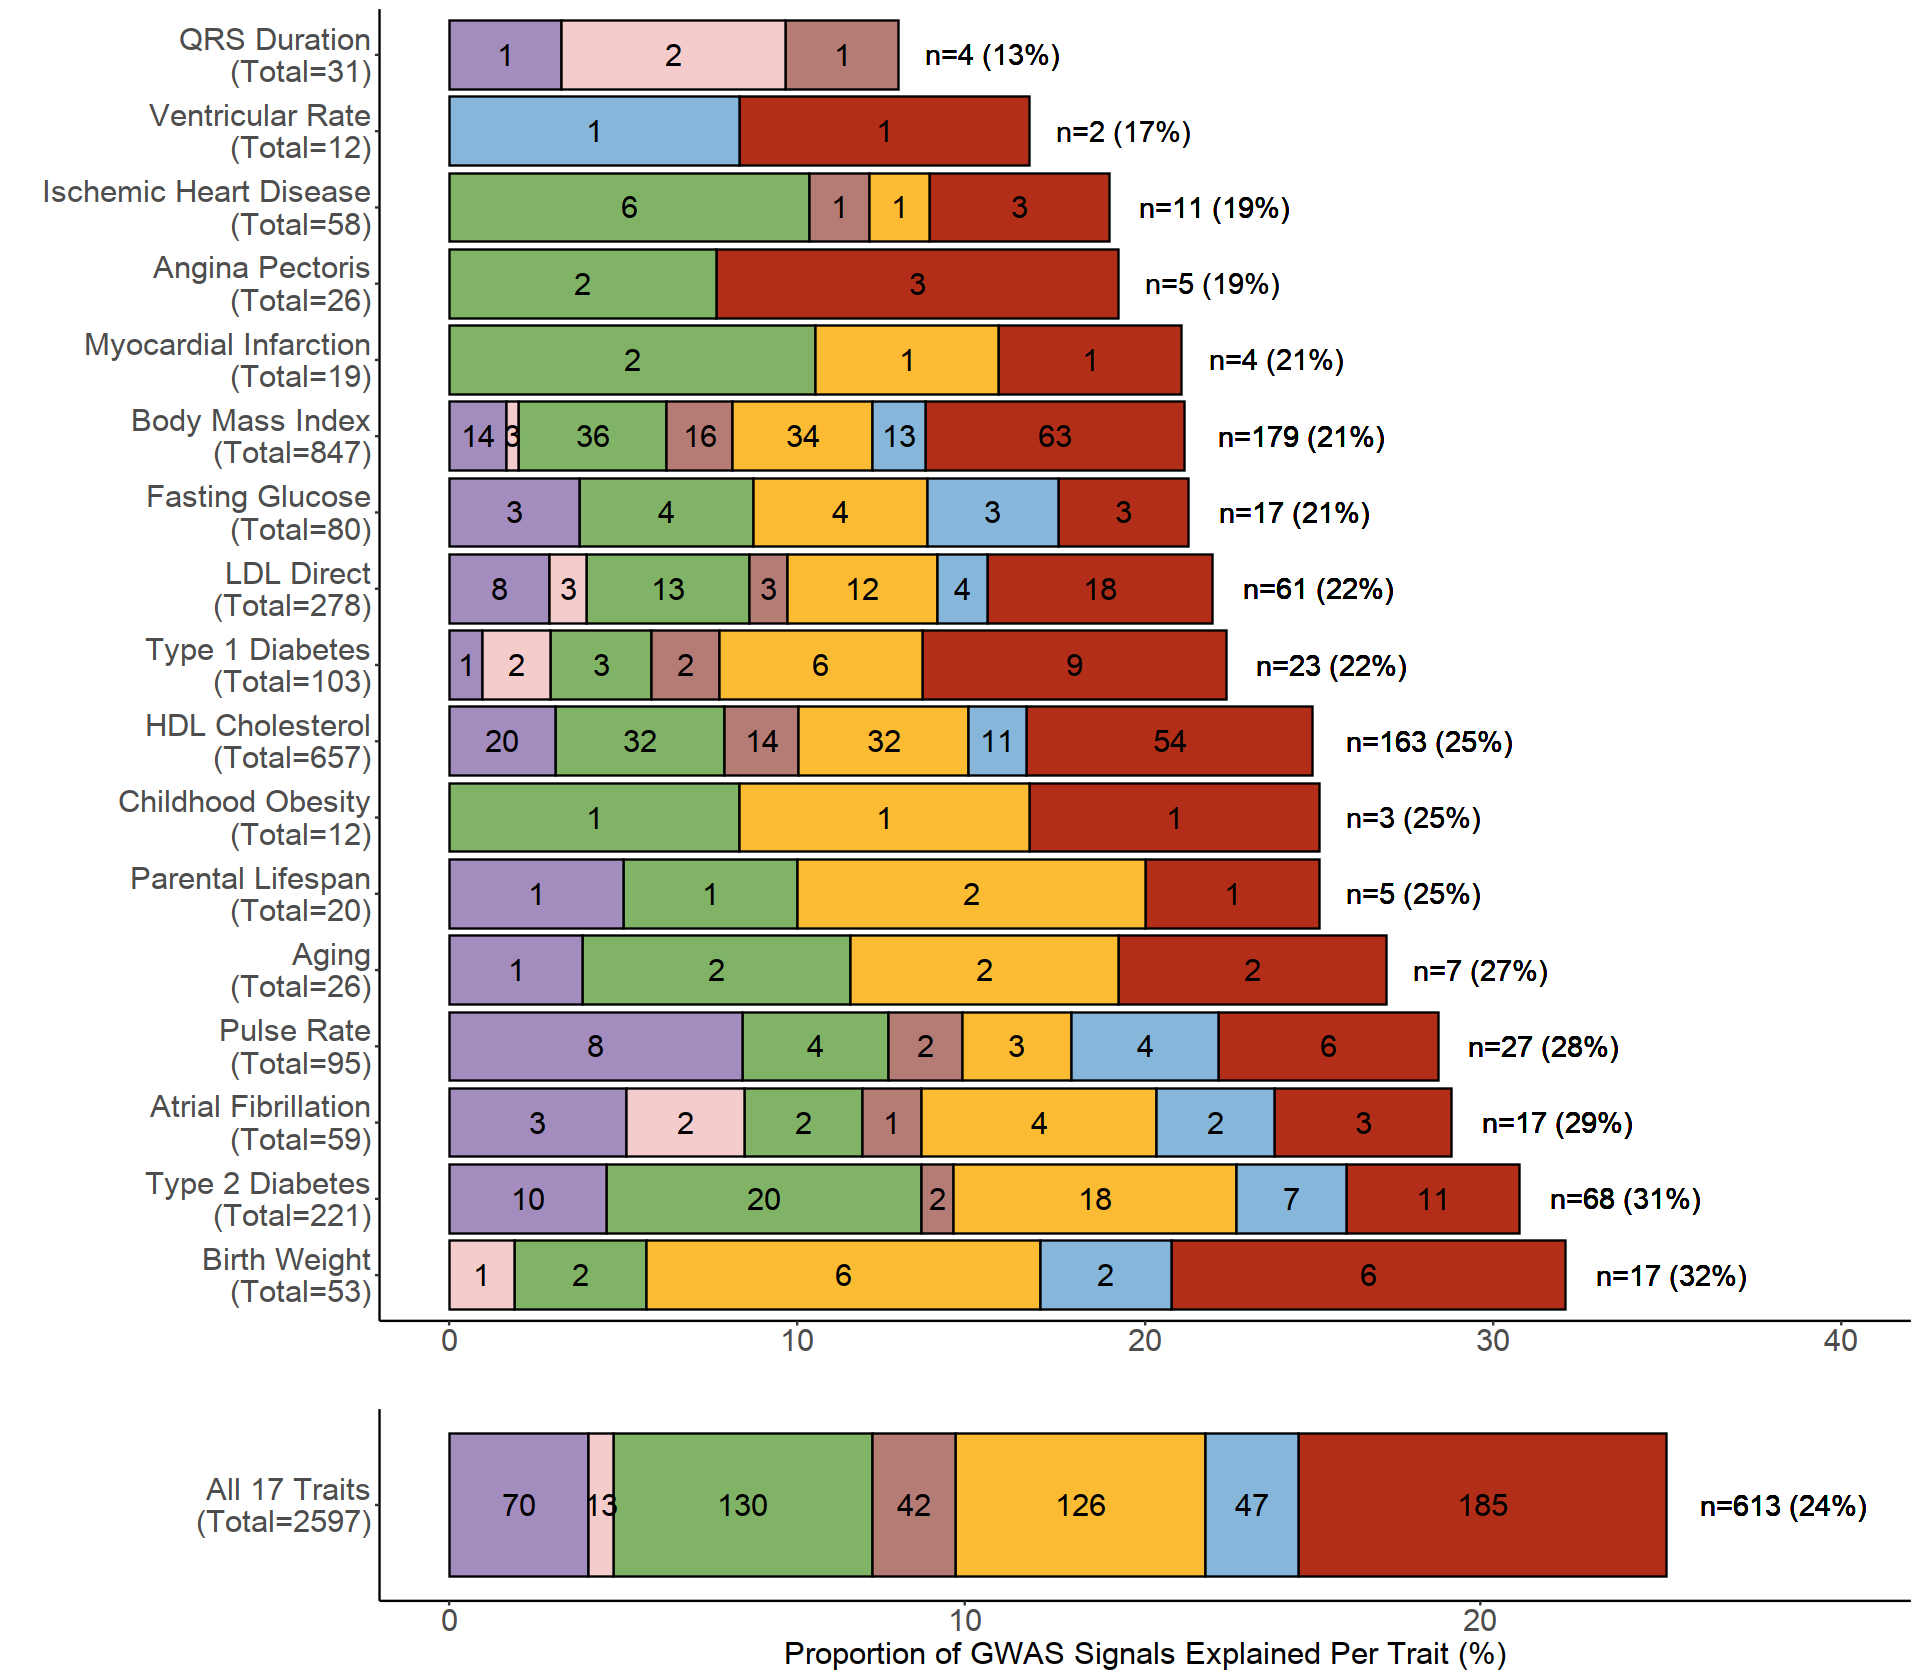

In [155]:
psize(w = 16, h = 14)
p2 = plot_grid(p0 + theme(legend.position = "none"), p1, ncol = 1, align = "hv", rel_heights = c(1, 0.2))
p2

## write source data

In [156]:
setdiff(colnames(all), colnames(toplot3))

setdiff(colnames(toplot3), colnames(all))

character(0)

character(0)

In [157]:
fwrite(rbind(all, toplot3) %>% dplyr::relocate(Trait_Description, .before = QTL_Annotations), 
       "manuscript/figures/SourceData.Figure5a.QTL_Combo_Per_Trait.txt", row.names = F, sep = "\t")

## re-order legend to the same order presented in bar plot

### reverse order of legend labels

In [162]:
qtl_order = rev(c("caQTL", "haQTL", "eQTL", "caQTL,haQTL", "caQTL,eQTL", "eQTL,haQTL", "caQTL,eQTL,haQTL"))
toplot3$QTL_Annotations = factor(toplot3$QTL_Annotations, levels = qtl_order)

### plot using reversed order of colors

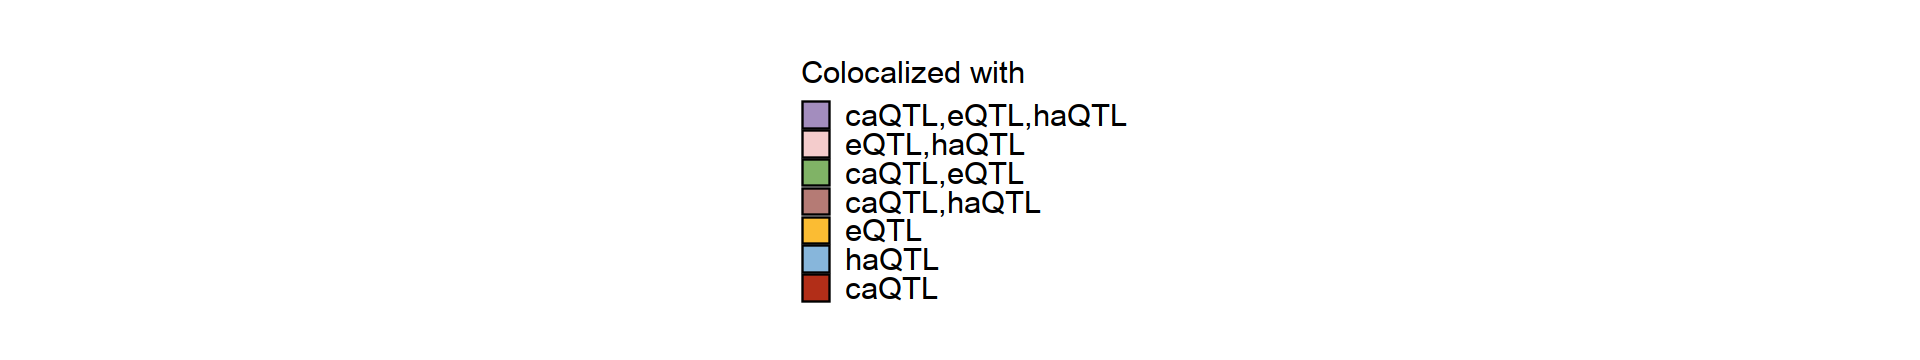

In [163]:
psize(w = 16, h = 3)
p0 = ggplot(toplot3, aes(x = Pct_Signals_Colocalized_with_Annotation, y = Trait_Description, fill = QTL_Annotations, label = Number_Signals_with_Annotation)) + 
    geom_bar(stat = "identity", color = "black") + 
    jn_classic + 
    theme(
#         legend.position = "none",
        legend.text = element_text(size = 18),
        legend.title = element_text(size = 18)
    ) + xlab("") + ylab("") + 
    scale_fill_manual(values = rev(c("#b22e18",
                                 "#87b6db",
                                 "#fbbc33", 
                                 "#b57b75",
                                 "#80b366",
                                 "#f4cccc",
                                 "#a38dbe")), 
                      name = "Colocalized with  ") +
     geom_text(position = position_stack(vjust = 0.5), size = 5.3) +
     geom_text(data = toplot3, aes(x = Total_Pct_Colocalized, y = Trait_Description, label = Bar_Label), color = "black",  hjust = -0.2, size = 6) + 
     xlim(0, 40)

library(grid)

plot_grid(get_legend(p0))